# Pump It Up Challenge: Driven Data

## Modules importing

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
from typing import List, Dict, Tuple, Union, Optional

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [134]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline, _fit_transform_one, _transform_one

from sklearn.cluster import KMeans

from joblib import Parallel, delayed

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Settings

In [5]:
PATH2PROJECT = Path('..')
PATH2CONFIGS = PATH2PROJECT / 'config'
PATH2DATA = PATH2PROJECT / 'data'
PATH2OUTPUT = PATH2PROJECT / 'output'

In [6]:
ID = 'id'
TARGET = 'status_group'
DATE = 'date_recorded'

In [140]:
SEED = 42

## Data Loading

In [7]:
df_test = pd.read_csv(PATH2DATA / 'Test_set_values.csv')
df_test.shape

(14850, 40)

In [8]:
df_train = pd.read_csv(PATH2DATA / 'training_Set_values.csv')
df_train.shape

(59400, 40)

In [9]:
y_train = pd.read_csv(PATH2DATA / 'training_Set_labels.csv')
y_train.shape

(59400, 2)

In [10]:
assert len(y_train.status_group.unique()) == 3

In [11]:
assert df_train.shape[0] == y_train.shape[0]

In [12]:
df_train = df_train.merge(y_train, on=ID, how='inner')
df_train.shape

(59400, 41)

In [13]:
assert df_train.shape[0] == y_train.shape[0]

## Simple EDA

In [81]:
numerical_columns = df_train.drop(columns=[ID, TARGET, 'region_code', 'district_code']).select_dtypes(include=['float', 'int']).columns.tolist()
categorical_columns = df_train.drop(columns=[ID, TARGET]).select_dtypes(include='object').columns.tolist() + ['region_code', 'district_code']

### Target

In [14]:
assert all(df_train.groupby(ID)[TARGET].count() == 1)

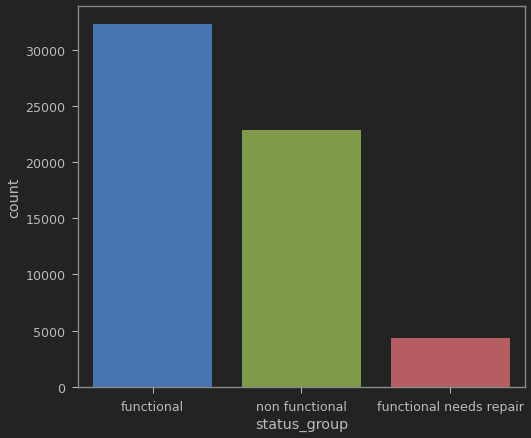

In [15]:
sns.countplot(x=df_train[TARGET]);

In [17]:
df_train[TARGET].value_counts(normalize=alize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [18]:
print('min id=%d; max id=%d' % (df_train[ID].min(), df_train[ID].max()))

min id=0; max id=74247


### Train data

In [83]:
df_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [85]:
df_train[numerical_columns].describe()

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,30500.000000,2013.000000


In [86]:
def simple_na_report(df: pd.DataFrame) -> pd.core.series.Series:
    t = df_train.isnull().sum() / len(df_train)
    return t[t > 0]

simple_na_report(df_train)

funder               0.061195
installer            0.061532
subvillage           0.006246
public_meeting       0.056128
scheme_management    0.065269
scheme_name          0.474175
permit               0.051448
dtype: float64

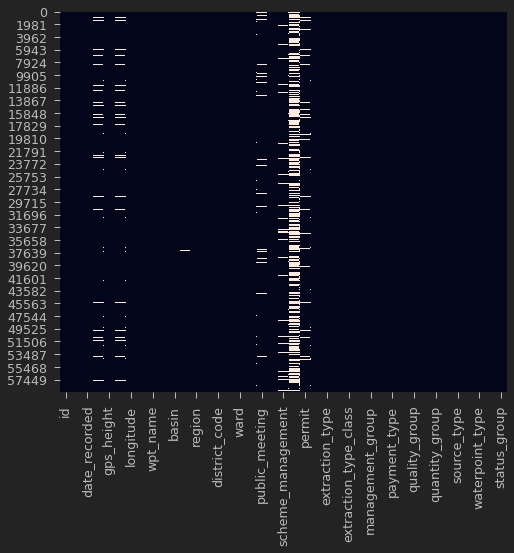

In [87]:
sns.heatmap(df_train.isnull(), cbar=False);

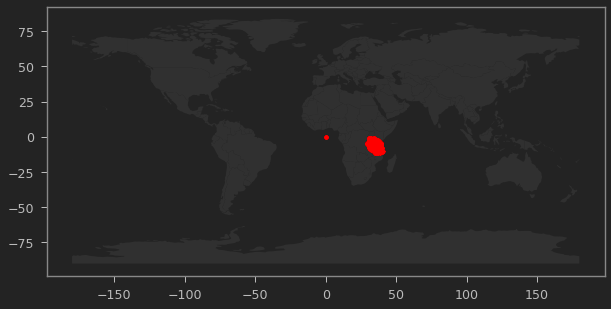

In [88]:
geometry = [Point(xy) for xy in zip(df_train['longitude'], df_train['latitude'])]
gdf = GeoDataFrame(geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=10);

In [89]:
for col in categorical_columns:
    if len(df_train[col].unique()) > 25:
        continue
    temp = df_train.groupby([col, TARGET]).count()[ID].reset_index()
    fig = px.bar(temp, x=col, y=ID, color=TARGET, title=f"{col} - count of id`s",width=1000, height=500)
    fig.show()
del temp

In [90]:
print('Columns with high cardinality:')
high_cardinality_columns = []
for col in categorical_columns:
    unique_cnt = len(df_train[col].unique())
    if unique_cnt > 25:
        high_cardinality_columns.append(col)
        print(f'- {col}: {unique_cnt} unique values')

Columns with high cardinality:
- funder: 1898 unique values
- installer: 2146 unique values
- wpt_name: 37400 unique values
- subvillage: 19288 unique values
- lga: 125 unique values
- ward: 2092 unique values
- scheme_name: 2697 unique values
- region_code: 27 unique values


In [91]:
print('Columns which contain minor categories:')
minor_cat_columns = []
for col in categorical_columns:
    minor_cnt = len([*filter(lambda x: x < 5e-2, df_train[col].value_counts(normalize=True).values)])
    if minor_cnt > 0:
        minor_cat_columns.append(col)
        print(f'- {col}: {minor_cnt} minor categories')

Columns which contain minor categories:
- funder: 1895 minor categories
- installer: 2144 minor categories
- wpt_name: 37399 minor categories
- basin: 1 minor categories
- subvillage: 19287 minor categories
- region: 13 minor categories
- lga: 125 minor categories
- ward: 2092 minor categories
- scheme_management: 8 minor categories
- scheme_name: 2696 minor categories
- extraction_type: 13 minor categories
- extraction_type_group: 8 minor categories
- extraction_type_class: 2 minor categories
- management: 10 minor categories
- management_group: 3 minor categories
- payment: 1 minor categories
- payment_type: 1 minor categories
- water_quality: 6 minor categories
- quality_group: 4 minor categories
- quantity: 1 minor categories
- quantity_group: 1 minor categories
- source: 6 minor categories
- source_type: 3 minor categories
- source_class: 1 minor categories
- waterpoint_type: 3 minor categories
- waterpoint_type_group: 3 minor categories
- region_code: 19 minor categories
- distri

## Data Preprocessing

## Feature Engineering

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_names: List[str]):
        self._feature_names = feature_names 
    
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        return X[self._feature_names]

In [ ]:
class FeatureDrop(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_names: List[str]):
        self._feature_names = feature_names 
    
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        return X.drop(columns=[self._feature_names])

In [ ]:
class ToDateTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_names):
        self._feature_names = feature_names
        
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        for feature in self._feature_names:
            X.loc[:, feature] =  pd.to_datetime(X[feature])
        return X

In [ ]:
class NumericalFeaturesGenerator(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        X['date_recorded_quarter_dt'] = X['date_recorded'].dt.quarter
        X['date_recorded_month_dt'] = X['date_recorded'].dt.month
        X['date_recorded_year_dt'] = X['date_recorded'].dt.year

        X['date_recorded_quarter_dt_sin'] = X['date_recorded_quarter_dt'].apply(lambda x: np.pi * np.sin(x) / 3)
        X['date_recorded_quarter_dt_cos'] = X['date_recorded_quarter_dt'].apply(lambda x: np.pi * np.cos(x) / 3)
        X['date_recorded_month_dt_sin'] = X['date_recorded_quarter_dt'].apply(lambda x: np.pi * np.sin(x) / 11)
        X['date_recorded_month_dt_cos'] = X['date_recorded_quarter_dt'].apply(lambda x: np.pi * np.cos(x) / 11)

        X['date_recorded_year_dt_sub_construction_year'] = X['date_recorded_year_dt'] - X['construction_year']
        X['date_recorded_year_dt_sub_construction_year_div_population'] = (X['date_recorded_year_dt'] - X['construction_year']) / X['population']

        X['amount_tsh_div_population'] = X['amount_tsh'] / X['population']
        
        return X

In [ ]:
class CategoricalKFoldMeanEncoding(EmptyCategoryEncodingTransformer):
    def __init__(self, weight: float = 10):
        super(TargetCategoryEncodingTransformer, self).__init__()
        self.fold_encoder = dict()
        self.test_encoder = dict()
        self.weight = weight

    def fit(self, ds):
        super(TargetCategoryEncodingTransformer, self).fit(ds)

        target_col = ds.get_target()
        if len(target_col) > 1:
            raise ValueError('Cannot deal with multidimensional target.')
        else:
            target_col = target_col[0]

        # train encoder by fold
        for fold_id, train, _ in ds.get_folds():
            self.fold_encoder[fold_id] = {}
            global_mean = train[target_col].mean()
            for feature in self.features_in:
                statistics = train.groupby(feature)[target_col].agg(['count', 'mean'])

                smooth_mean = ((statistics['count'] * statistics['mean'] + self.weight * global_mean) / (
                            statistics['count'] + self.weight)).to_dict()
                self.fold_encoder[fold_id][feature] = smooth_mean

        # train encoder using all records
        train = ds.get_dataset()
        global_mean = train[target_col].mean()
        for feature in self.features_in:
            statistics = train.groupby(feature)[target_col].agg(['count', 'mean'])

            smooth_mean = ((statistics['count'] * statistics['mean'] + self.weight * global_mean) / (
                        statistics['count'] + self.weight)).to_dict()
            self.test_encoder[feature] = smooth_mean

        self.features_out = self.features_in

        return self

    def transform(self, ds):
        encoded = []
        if ds.is_train():
            for fold_id, valid in ds.get_valid_folds():
                fold_encoded = {}
                for feature in self.features_in:
                    fold_encoded[feature] = valid[feature].map(self.fold_encoder[fold_id][feature])

                encoded.append(pd.DataFrame(fold_encoded))
        else:
            fold_encoded = {}
            test = ds.get_dataset()
            for feature in self.features_in:
                fold_encoded[feature] = test[feature].map(self.test_encoder[feature])
            encoded.append(pd.DataFrame(fold_encoded))

        encoded = pd.concat(encoded)

        roles = []
        for cf in self.features_in:
            processed = [f for f in self.features_out if f.startswith(cf)]
            roles.append(FeatureRole(column=cf, dtype='categorical', processed=processed))
        ds = ds.update(df=encoded[self.features_out], roles=roles)

        return ds

In [ ]:
class CoodrinatesFeaturesGenerator(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_clusters=7, random_state=42):
        self.clustering = KMeans(n_clusters=n_clusters, random_state=self.random_state)
        
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        self.clustering.fit(X)
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        X['clustering_labels'] = self.clustering.transform(X)
        return X

In [ ]:
class StandardScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        from sklearn.preprocessing import StandardScaler as SS
        self.scaler = SS()
    
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        self.scaler.fit(X)
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        idx = X.index
        result = pd.DataFrame(self.scaler.transform(X), columns=X.columns)
        result['id'] = idx
        return result.set_index('id')


In [ ]:
class SimpleImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, strategy: str = 'mean'):
        from sklearn.impute import SimpleImputer as SI
        self.imputer = SI(strategy=strategy)
    
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        self.imputer.fit(X)
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        idx = X.index
        result = pd.DataFrame(self.imputer.transform(X), columns=X.columns)
        result['id'] = idx
        return result.set_index('id')

In [ ]:
class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans,
                X=X,
                y=y,
                weight=weight,
                **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(
                transformer=trans,
                X=X,
                y=None,
                weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

In [ ]:
# to_date_transformer = ToDateTransformer(columns=[DATE])

In [ ]:
numerical_columns = df_train.drop(columns=[ID, TARGET, 'region_code', 'district_code']).select_dtypes(include=['float', 'int']).columns.tolist()
categorical_columns = df_train.drop(columns=[ID, TARGET]).select_dtypes(include='object').columns.tolist() + ['region_code', 'district_code']

categorical_columns = list(set(categorical_columns) - set(high_cardinality_columns))

In [ ]:
categorical_pipeline = PandasFeatureUnion(transformer_list=[
    ('cat_column', Pipeline(steps=[
        ('cat_selector', FeatureSelector(categorical_columns)),
        ('cat_kfold_mean_encoding', CategoricalKFoldMeanEncoding()),
    ])),
    ('clustering_labels', Pipeline(steps=[
        ('coords_selector', FeatureSelector(['latitude', 'longitude'])),
        ('coords_clustering', CoodrinatesFeaturesGenerator(n_clusters=7, random_state=SEED)),
        ('drop_coords', FeatureSelector(['latitude', 'longitude'])),
        ('coords_kfold_mean_encoding', CategoricalKFoldMeanEncoding()),
    ])),
])

numerical_pipeline = Pipeline(steps=[
    ('num_selector', FeatureSelector(numerical_columns+[DATE])),
    ('num_features_generator', NumericalFeaturesGenerator()),
    ('drop_date', FeatureSelector([DATE])),
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler()),
])

features_pipeline = PandasFeatureUnion(transformer_list=[
    ('categorical_pipeline', categorical_pipeline),
    ('numerical_pipeline', numerical_pipeline),
])

## Dimensionality Reduction & Anomaly Detection

## Feature Selection

## Hyperparameters tuning

## Cross-validate model

## Training final model

## Validation final model

## Prediction

## Save results!